In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from wordcloud import WordCloud

import statsmodels.api as sm


# Load CSVs

In [4]:
raw_interactions = pd.read_csv("data/RAW_interactions.csv")

In [5]:
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
raw_interactions.shape

(1132367, 5)

In [7]:
raw_interactions = raw_interactions.dropna(subset=["review"])

In [8]:
raw_interactions.shape

(1132198, 5)

In [9]:
raw_interactions.drop_duplicates(inplace=True)

# Raw recipes

In [10]:
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [11]:
raw_recipes.isna().any()

name               True
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
nutrition         False
n_steps           False
steps             False
description        True
ingredients       False
n_ingredients     False
dtype: bool

In [12]:
raw_recipes = raw_recipes.dropna(subset=["name", "description"])

In [13]:
raw_recipes.isna().any()

name              False
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
nutrition         False
n_steps           False
steps             False
description       False
ingredients       False
n_ingredients     False
dtype: bool

In [14]:
raw_recipes.shape

(226657, 12)

In [15]:
raw_recipes.drop_duplicates(inplace=True)

In [16]:
raw_recipes["ingredients"] = raw_recipes["ingredients"].apply(lambda x: eval(x) if x == x else np.nan)

In [17]:
raw_recipes = raw_recipes[raw_recipes.minutes <= 300]

In [18]:
raw_recipes.shape

(216892, 12)

In [19]:
raw_recipes['nutrition'] = raw_recipes['nutrition'].str.strip('[]').str.split(',')

In [20]:
nutrition_columns = ['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carb']
raw_recipes[nutrition_columns] = pd.DataFrame(raw_recipes['nutrition'].tolist(), index=raw_recipes.index)
raw_recipes = raw_recipes.drop(columns=['nutrition'])

In [21]:
raw_recipes.shape

(216892, 18)

In [22]:
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,fat,sugar,sodium,protein,saturated_fat,carb
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


 nutrition:  (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV) , and carbohydrates (PDV))

In [23]:
raw_recipes.rename({"id": "recipe_id"}, axis=1, inplace=True)

In [24]:
raw_recipes.isna().any()

name              False
recipe_id         False
minutes           False
contributor_id    False
submitted         False
tags              False
n_steps           False
steps             False
description       False
ingredients       False
n_ingredients     False
calories          False
fat               False
sugar             False
sodium            False
protein           False
saturated_fat     False
carb              False
dtype: bool

Find recipes with most interactions

In [25]:
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [26]:
raw_interactions["recipe_id"].value_counts() 

recipe_id
2886      1609
27208     1601
89204     1579
39087     1448
67256     1322
          ... 
145160       1
87750        1
60656        1
310237       1
306785       1
Name: count, Length: 231630, dtype: int64

TODO neki plot

# Get recipes with >= 10 reviews

In [27]:
merged_df = pd.merge(raw_recipes, raw_interactions, on='recipe_id')
reviews_count = merged_df.groupby('recipe_id').size().reset_index(name='review_count')
reviews_count

,recipe_id,review_count
0,39,1
1,40,9
2,43,1
3,45,3
4,46,2
...,...,...
216881,537459,1
216882,537485,1
216883,537543,1
216884,537671,1


In [28]:
recipes_to_keep = reviews_count[reviews_count.review_count >= 10].recipe_id.values

In [29]:
len(recipes_to_keep)

19854

In [30]:
#top_1000_recipes = raw_interactions["recipe_id"].value_counts().index[:1000]
#top_1000_recipes

In [31]:
interactions_df = raw_interactions[raw_interactions.recipe_id.isin(recipes_to_keep)].copy()
interactions_df.shape

(557943, 5)

In [32]:
recipes_df = raw_recipes[raw_recipes.recipe_id.isin(recipes_to_keep)].copy()
recipes_df.shape

(19854, 18)

In [33]:
recipes_df['calories'] = pd.to_numeric(recipes_df['calories'], errors='coerce')
recipes_df['fat'] = pd.to_numeric(recipes_df['fat'], errors='coerce')
recipes_df['sugar'] = pd.to_numeric(recipes_df['sugar'], errors='coerce')
recipes_df['protein'] = pd.to_numeric(recipes_df['protein'], errors='coerce')
recipes_df['carb'] = pd.to_numeric(recipes_df['carb'], errors='coerce')
recipes_df['sodium'] = pd.to_numeric(recipes_df['carb'], errors='coerce')
recipes_df['saturated_fat'] = pd.to_numeric(recipes_df['saturated_fat'], errors='coerce')

In [34]:
Q1 = recipes_df['calories'].quantile(0.25)
Q3 = recipes_df['calories'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (recipes_df['calories'] >= Q1 - 1.5 * IQR) & (recipes_df['calories'] <= Q3 + 1.5 *IQR)
recipes_df = recipes_df.loc[filter]

In [35]:
recipes_df

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,fat,sugar,sodium,protein,saturated_fat,carb
16,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"[egg roll wrap, whole green chilies, cheese, c...",5,94.0,10.0,0.0,0.0,11.0,21.0,0.0
17,chinese candy,23933,15,35268,2002-03-29,"['15-minutes-or-less', 'time-to-make', 'course...",4,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...","[butterscotch chips, chinese noodles, salted p...",3,232.7,21.0,77.0,8.0,6.0,38.0,8.0
33,grilled venison burgers,54100,26,68357,2003-02-15,"['30-minutes-or-less', 'time-to-make', 'course...",13,"['in bowl , mix dry ingredients', 'add venison...",delicious venison burgers with that,"[ground venison, egg substitute, non-fat powde...",10,190.9,10.0,10.0,2.0,45.0,15.0,2.0
34,healthy for them yogurt popsicles,67664,10,91970,2003-07-26,"['15-minutes-or-less', 'time-to-make', 'course...",3,"['mix all the ingredients using a blender', 'p...",my children and their friends ask for my homem...,"[milk, frozen juice concentrate, plain yogurt]",3,164.6,3.0,5.0,11.0,4.0,6.0,11.0
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","[frozen chopped spinach, egg, salt, black pepp...",8,166.1,16.0,6.0,3.0,19.0,26.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231528,zucchini corn casserole,126852,60,28604,2005-06-21,"['60-minutes-or-less', 'time-to-make', 'course...",8,['trim and scrub zucchini and cook them in boi...,my grandma lorraine stromgren would listen to ...,"[zucchini, cream-style corn, eggs, butter, oni...",10,195.1,16.0,23.0,6.0,19.0,28.0,6.0
231539,zucchini parmesan pancakes,70501,26,89831,2003-09-04,"['30-minutes-or-less', 'time-to-make', 'course...",6,"['in a bowl , combine all ingredients except b...","if you love zucchini and parmesan cheese, then...","[flour, parmesan cheese, dried oregano, salt a...",11,397.2,43.0,15.0,8.0,23.0,51.0,8.0
231566,zucotte,96811,65,65056,2004-08-03,"['time-to-make', 'course', 'main-ingredient', ...",10,"['in a large , heavy saucpan , melt 1 tbs of t...",a garlicky braised winter squash dish that cou...,"[butter, white wine, garlic, butternut squash,...",6,145.7,13.0,10.0,5.0,3.0,27.0,5.0
231587,zuppa di pesce cioppino or fish stew,116488,60,58104,2005-04-12,"['60-minutes-or-less', 'time-to-make', 'course...",9,['in a pot add 5 cups water and shrimp shells ...,whatever you may call it this italian named fi...,"[olive oil, onions, garlic cloves, anchovies, ...",29,160.3,3.0,17.0,4.0,37.0,2.0,4.0


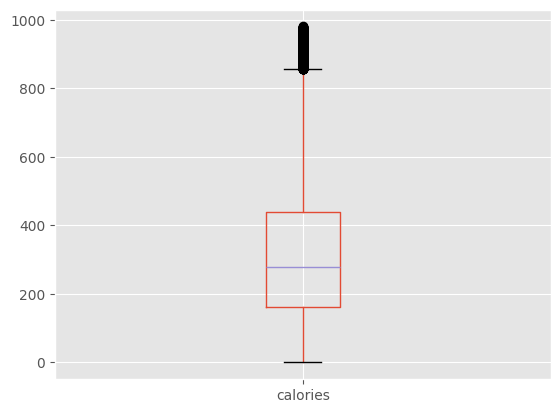

In [36]:
recipes_df[["calories"]].boxplot()
plt.show()

In [37]:
sia = SentimentIntensityAnalyzer()

In [38]:
recipes_df['recipe_VADER_compound'] = recipes_df['description'].apply(lambda x: sia.polarity_scores(x)['compound']).astype(float)

In [39]:
recipes_df['recipe_VADER_class'] = recipes_df['recipe_VADER_compound'].apply(lambda x: "Positive" if x > 0.5 else ("Negative" if x < -0.5 else "Neutral"))

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb


merged_df = pd.merge(recipes_df, interactions_df, on='recipe_id')
reviews_count = merged_df.groupby('recipe_id').size().reset_index(name='review_count')
recipes_with_reviews = pd.merge(recipes_df, reviews_count, on='recipe_id')

high_df = recipes_with_reviews[recipes_with_reviews["review_count"] > recipes_with_reviews["review_count"].quantile(0.75)].copy()
high_df["high_eng"] = 1

low_df= recipes_with_reviews[recipes_with_reviews["review_count"] < recipes_with_reviews["review_count"].quantile(0.25)].copy()
low_df["high_eng"] = 0


df = pd.concat([high_df, low_df], axis=0, ignore_index=True)
#df.columns
df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,fat,sugar,sodium,protein,saturated_fat,carb,recipe_VADER_compound,recipe_VADER_class,review_count,high_eng
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","[frozen chopped spinach, egg, salt, black pepp...",...,16.0,6.0,3.0,19.0,26.0,3.0,0.8980,Positive,113,1
1,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"[rolls, brown sugar, instant vanilla pudding, ...",...,18.0,116.0,34.0,28.0,22.0,34.0,0.8074,Positive,51,1
2,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","[whipping cream, vanilla instant pudding mix, ...",...,45.0,2.0,0.0,3.0,91.0,0.0,-0.2242,Neutral,80,1
3,say what banana sandwich,95926,5,118163,2004-07-20,"['15-minutes-or-less', 'time-to-make', 'course...",4,['spread a tablespoon on one side of each slic...,you just have to try it to believe it.,"[white bread, mayonnaise, bananas]",...,3.0,66.0,17.0,10.0,2.0,17.0,0.0000,Neutral,43,1
4,the best banana bread or muffins,39363,70,51579,2002-09-03,"['weeknight', 'time-to-make', 'course', 'main-...",10,"['cream together butter and sugar', 'blend in ...","okay, another banana bread recipe...but maybe ...","[butter, sugar, eggs, bananas, water, baking s...",...,9.0,65.0,9.0,5.0,18.0,9.0,0.7339,Positive,27,1


In [41]:
df['tags'] = df['tags'].str.strip("[]").str.replace("'", "").str.split(',')
df["n_tags"] = df["tags"].apply(lambda x: len(x))
df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,sugar,sodium,protein,saturated_fat,carb,recipe_VADER_compound,recipe_VADER_class,review_count,high_eng,n_tags
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"[60-minutes-or-less, time-to-make, course, ...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","[frozen chopped spinach, egg, salt, black pepp...",...,6.0,3.0,19.0,26.0,3.0,0.8980,Positive,113,1,25
1,land of nod cinnamon buns,22526,35,29212,2002-03-14,"[60-minutes-or-less, time-to-make, course, ...",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"[rolls, brown sugar, instant vanilla pudding, ...",...,116.0,34.0,28.0,22.0,34.0,0.8074,Positive,51,1,9
2,never weep whipped cream,74805,5,87877,2003-11-01,"[15-minutes-or-less, time-to-make, course, ...",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","[whipping cream, vanilla instant pudding mix, ...",...,2.0,0.0,3.0,91.0,0.0,-0.2242,Neutral,80,1,14
3,say what banana sandwich,95926,5,118163,2004-07-20,"[15-minutes-or-less, time-to-make, course, ...",4,['spread a tablespoon on one side of each slic...,you just have to try it to believe it.,"[white bread, mayonnaise, bananas]",...,66.0,17.0,10.0,2.0,17.0,0.0000,Neutral,43,1,30
4,the best banana bread or muffins,39363,70,51579,2002-09-03,"[weeknight, time-to-make, course, main-ingr...",10,"['cream together butter and sugar', 'blend in ...","okay, another banana bread recipe...but maybe ...","[butter, sugar, eggs, bananas, water, baking s...",...,65.0,9.0,5.0,18.0,9.0,0.7339,Positive,27,1,22


#  Embed name

In [42]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

from tqdm import tqdm

c:\Users\Gabriela\anaconda3\envs\css-course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"

In [44]:
sentence_model = SentenceTransformer(model_name)

In [45]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [46]:
tqdm.pandas()

In [47]:
# just a validity check
def tokenize_row(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)

def embed_title(text):
    embedding = sentence_model.encode(text, normalize_embeddings=True)
    return embedding

In [48]:
df['name'].progress_apply(tokenize_row)

100%|██████████| 8607/8607 [00:00<00:00, 22425.50it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
8602    None
8603    None
8604    None
8605    None
8606    None
Name: name, Length: 8607, dtype: object

In [51]:
df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,sugar,sodium,protein,saturated_fat,carb,recipe_VADER_compound,recipe_VADER_class,review_count,high_eng,n_tags
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"[60-minutes-or-less, time-to-make, course, ...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","[frozen chopped spinach, egg, salt, black pepp...",...,6.0,3.0,19.0,26.0,3.0,0.8980,Positive,113,1,25
1,land of nod cinnamon buns,22526,35,29212,2002-03-14,"[60-minutes-or-less, time-to-make, course, ...",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"[rolls, brown sugar, instant vanilla pudding, ...",...,116.0,34.0,28.0,22.0,34.0,0.8074,Positive,51,1,9
2,never weep whipped cream,74805,5,87877,2003-11-01,"[15-minutes-or-less, time-to-make, course, ...",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","[whipping cream, vanilla instant pudding mix, ...",...,2.0,0.0,3.0,91.0,0.0,-0.2242,Neutral,80,1,14
3,say what banana sandwich,95926,5,118163,2004-07-20,"[15-minutes-or-less, time-to-make, course, ...",4,['spread a tablespoon on one side of each slic...,you just have to try it to believe it.,"[white bread, mayonnaise, bananas]",...,66.0,17.0,10.0,2.0,17.0,0.0000,Neutral,43,1,30
4,the best banana bread or muffins,39363,70,51579,2002-09-03,"[weeknight, time-to-make, course, main-ingr...",10,"['cream together butter and sugar', 'blend in ...","okay, another banana bread recipe...but maybe ...","[butter, sugar, eggs, bananas, water, baking s...",...,65.0,9.0,5.0,18.0,9.0,0.7339,Positive,27,1,22


In [52]:
cols_to_drop = ["name", "submitted", "recipe_id", "steps", "description", "tags", "ingredients", "recipe_VADER_class", "review_count", "high_eng"]

In [53]:
X = df.drop(columns=cols_to_drop)#.apply(pd.to_numeric, errors='coerce')
y = df['high_eng']

In [54]:
X.head()

,minutes,contributor_id,n_steps,n_ingredients,calories,fat,sugar,sodium,protein,saturated_fat,carb,recipe_VADER_compound,n_tags
0,50,37305,5,8,166.1,16.0,6.0,3.0,19.0,26.0,3.0,0.8980,25
1,35,29212,7,6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,0.8074,9
2,5,87877,4,4,276.3,45.0,2.0,0.0,3.0,91.0,0.0,-0.2242,14
3,5,118163,4,3,238.0,3.0,66.0,17.0,10.0,2.0,17.0,0.0000,30
4,70,51579,10,11,175.7,9.0,65.0,9.0,5.0,18.0,9.0,0.7339,22


In [55]:
#X = np.vstack(X.to_numpy())

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

X_train_transformed = X_train
X_test_transformed = X_test

model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {auc:.2f}')

final_model = model


Accuracy: 0.57
AUC-ROC: 0.56


c:\Users\Gabriela\anaconda3\envs\css-course\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


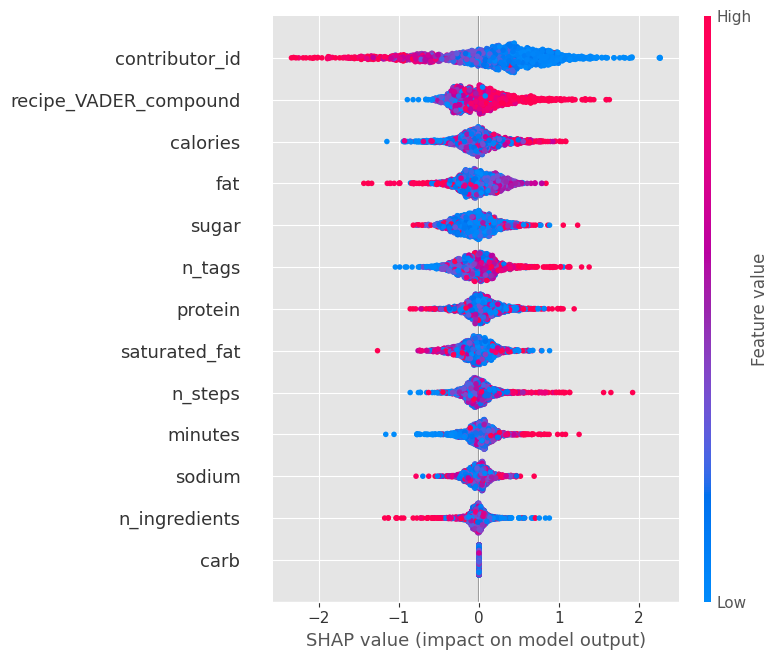

In [59]:
import shap

explainer = shap.Explainer(final_model, X_test_transformed)#, feature_names=feature_names) 
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)

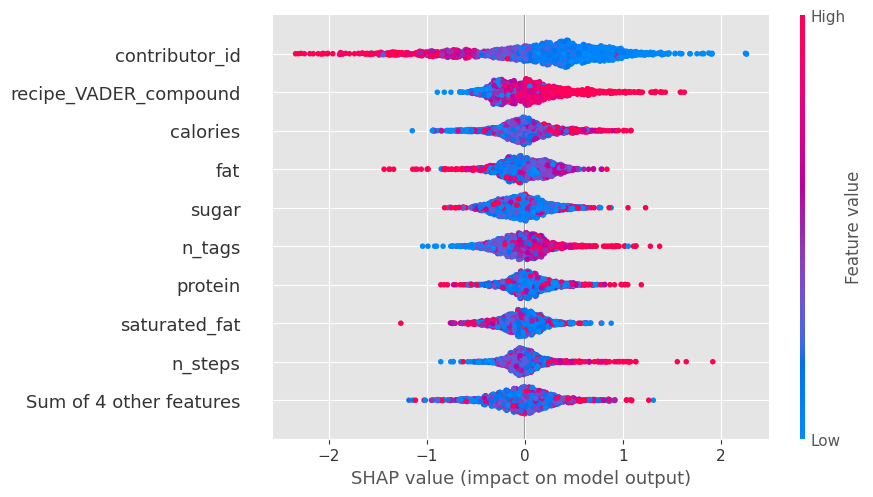

In [60]:
shap.plots.beeswarm(shap_values)


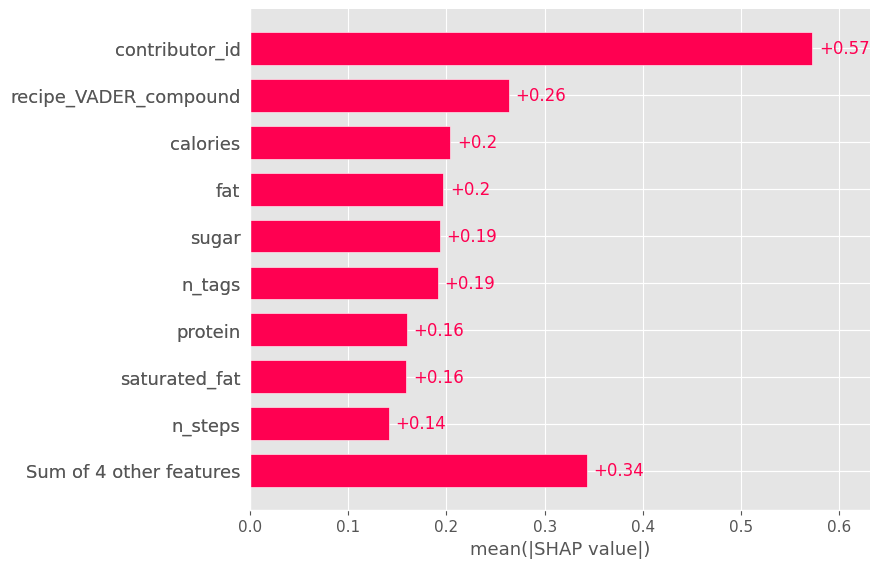

In [61]:
shap.plots.bar(shap_values)

In [62]:
X_test_with_names = X_test.copy()
X_test_with_names['name'] = df.loc[X_test.index, 'name'] 

In [78]:
df.iloc[453]

name                                          benihana japanese fried rice
recipe_id                                                            71472
minutes                                                                 40
contributor_id                                                       93698
submitted                                                       2003-09-15
tags                     [60-minutes-or-less,  time-to-make,  course,  ...
n_steps                                                                  9
steps                    ['cook rice following instructions on package'...
description                               source: www.topsecretrecipes.com
ingredients              [cooked rice, frozen peas, carrots, eggs, onio...
n_ingredients                                                            9
calories                                                             356.6
fat                                                                   11.0
sugar                    

In [83]:
df.iloc[453].description

'source: www.topsecretrecipes.com'

In [82]:
df.iloc[7837]

name                                                      shrimp cole slaw
recipe_id                                                           121425
minutes                                                                 25
contributor_id                                                      214763
submitted                                                       2005-05-10
tags                     [30-minutes-or-less,  time-to-make,  course,  ...
n_steps                                                                  6
steps                    ['clean cooked shrimp and break in half if lar...
description              a few years ago my husband and i were in kemah...
ingredients              [coleslaw, cooked shrimp, bell pepper, green o...
n_ingredients                                                            8
calories                                                             297.3
fat                                                                   24.0
sugar                    

In [84]:
df.iloc[7837].description

'a few years ago my husband and i were in kemah, and with our meal, we were served regular coleslaw with bits of shrimp in it. the slaw was good but we felt that it needed something to spice it up, so i came up with my own recipe. during the hot summer months we enjoy it as a light meal with toasted garlic bread, on these occasion i use 2 pounds of shrimp. every time i serve this salad it is a big hit and i never have any left over.\r\n    in order to save preparation time i have the grocer steam the shrimp in cajun spice, while i do the rest of my shopping.\r\n\r\nnote: the dressing will taste stronger before you toss it with the salad, the salad dilutes the taste of the dressing.'

In [81]:
X_test_with_names.iloc[8]

minutes                                25
contributor_id                     214763
n_steps                                 6
n_ingredients                           8
calories                            297.3
fat                                  24.0
sugar                                17.0
sodium                                7.0
protein                              35.0
saturated_fat                        12.0
carb                                  7.0
recipe_VADER_compound              0.9432
n_tags                                 24
name                     shrimp cole slaw
Name: 7837, dtype: object

In [76]:
X_test

,minutes,contributor_id,n_steps,n_ingredients,calories,fat,sugar,sodium,protein,saturated_fat,carb,recipe_VADER_compound,n_tags
453,40,93698,9,9,356.6,11.0,11.0,20.0,21.0,18.0,20.0,0.0000,26
7488,30,47559,11,10,191.4,12.0,17.0,8.0,11.0,6.0,8.0,0.8805,23
7348,65,226066,6,12,367.9,20.0,115.0,18.0,18.0,22.0,18.0,0.0000,11
8498,15,485109,9,5,263.7,16.0,117.0,13.0,4.0,32.0,13.0,0.9369,20
4296,27,37449,5,7,112.2,0.0,3.0,7.0,10.0,0.0,7.0,0.8687,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,60,263542,28,13,456.6,41.0,143.0,16.0,8.0,57.0,16.0,0.9370,14
5818,60,171790,12,5,330.5,24.0,55.0,8.0,40.0,42.0,8.0,0.5994,27
3680,105,166475,7,19,241.5,23.0,14.0,2.0,38.0,29.0,2.0,0.4753,21
425,150,52282,6,19,328.3,14.0,17.0,10.0,62.0,14.0,10.0,0.0000,24


Prediction for food 0: benihana japanese fried rice


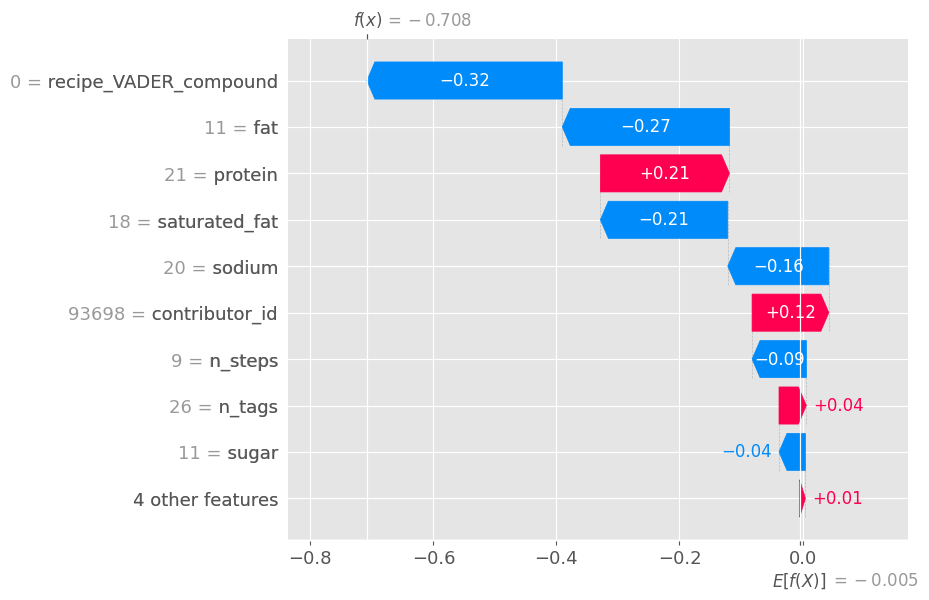

Prediction for food 1: potato hash


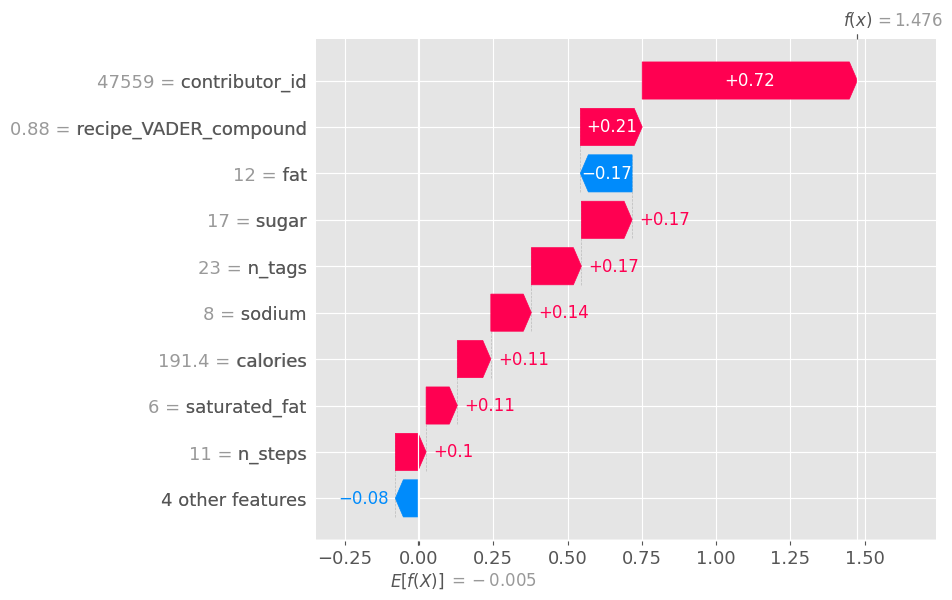

Prediction for food 2: peanut butter chocolate chip banana bread


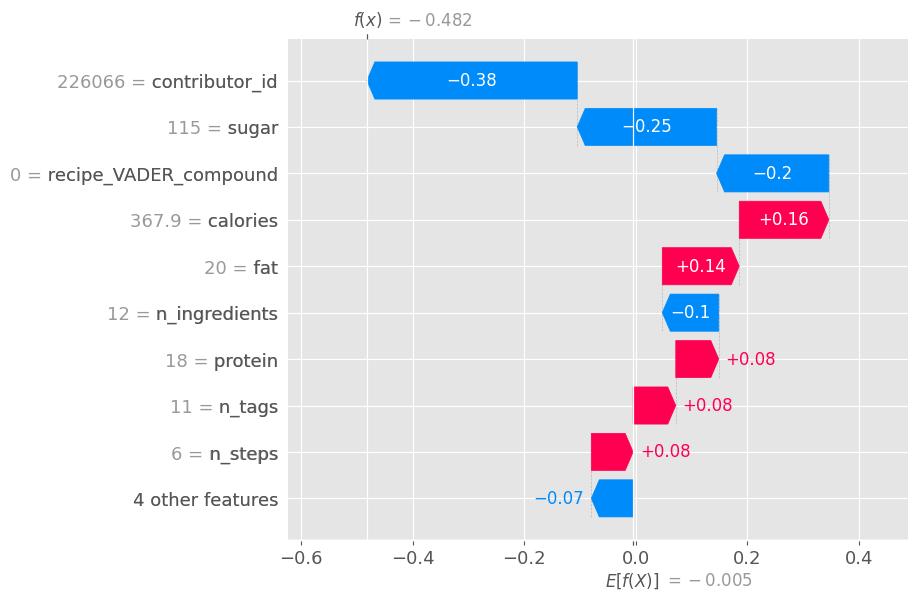

Prediction for food 3: white chocolate and maple rice krispie squares


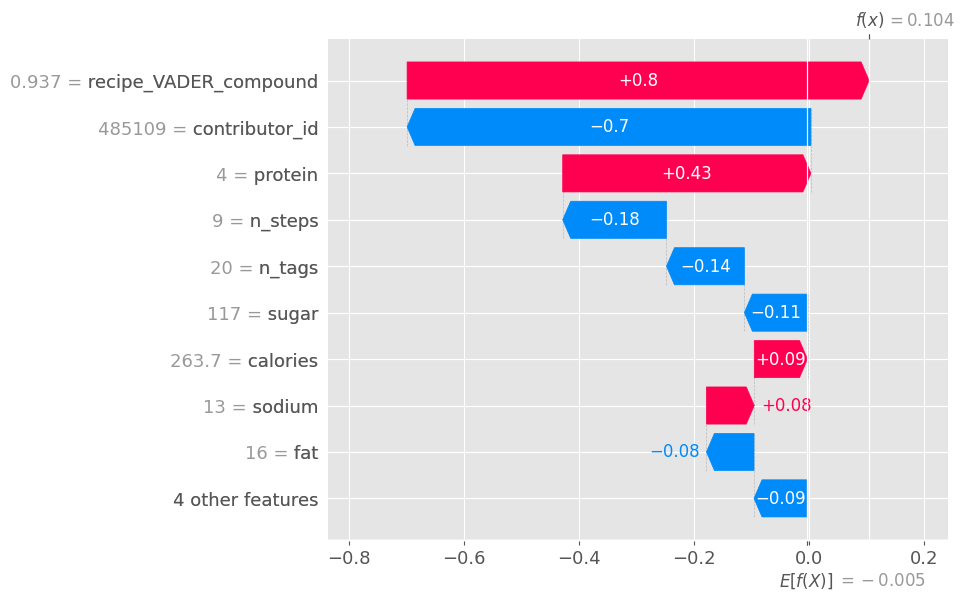

Prediction for food 4: va voom veggie burgers


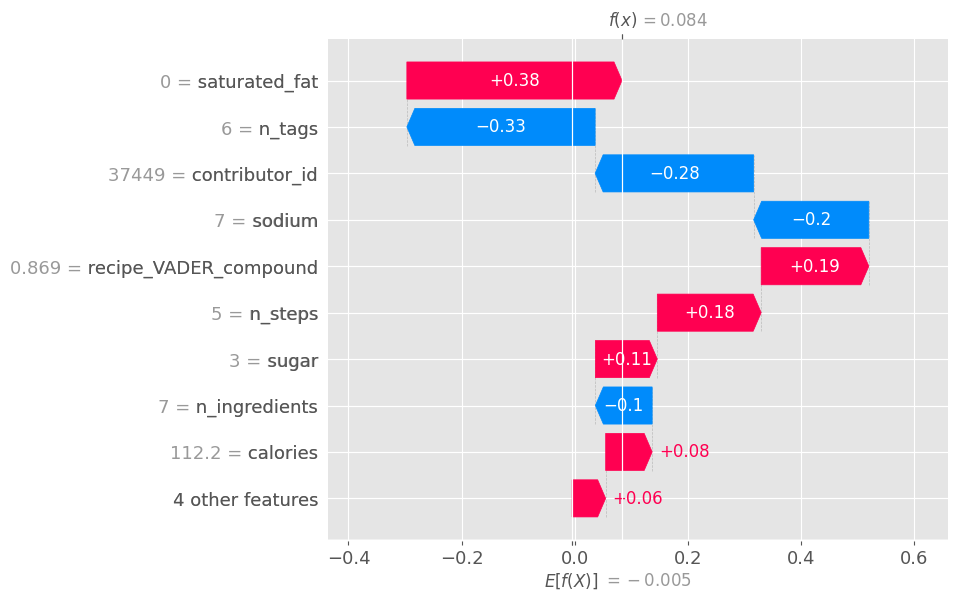

Prediction for food 5: poor man s pudding cake  pouding chomeur


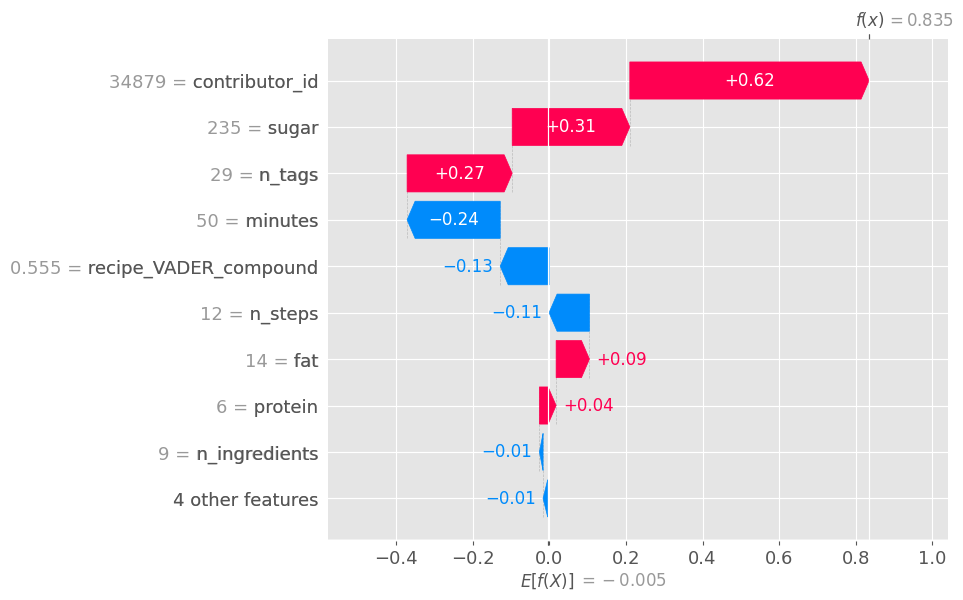

Prediction for food 6: my o my   best thai beef salad ever


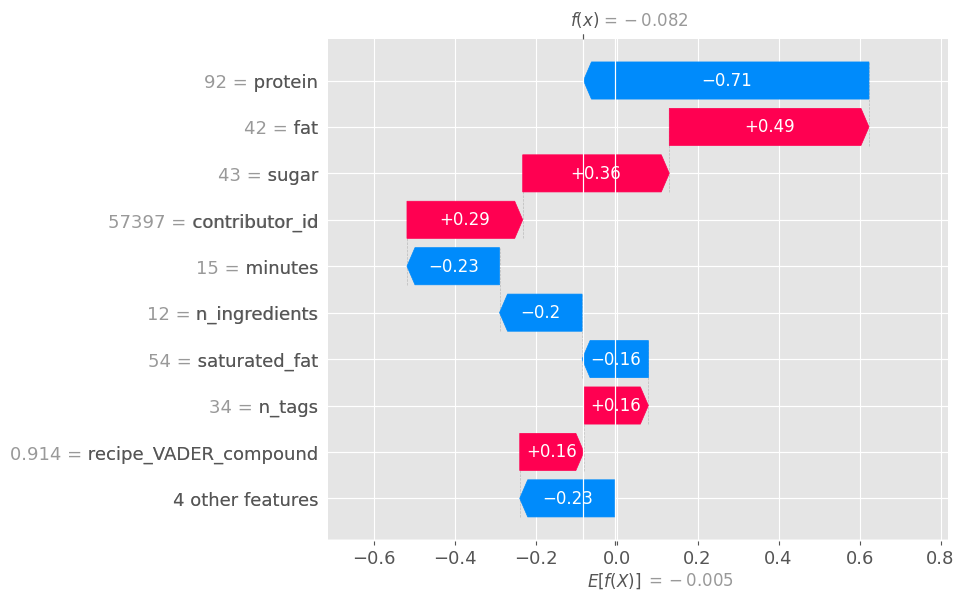

Prediction for food 7: haddock casserole


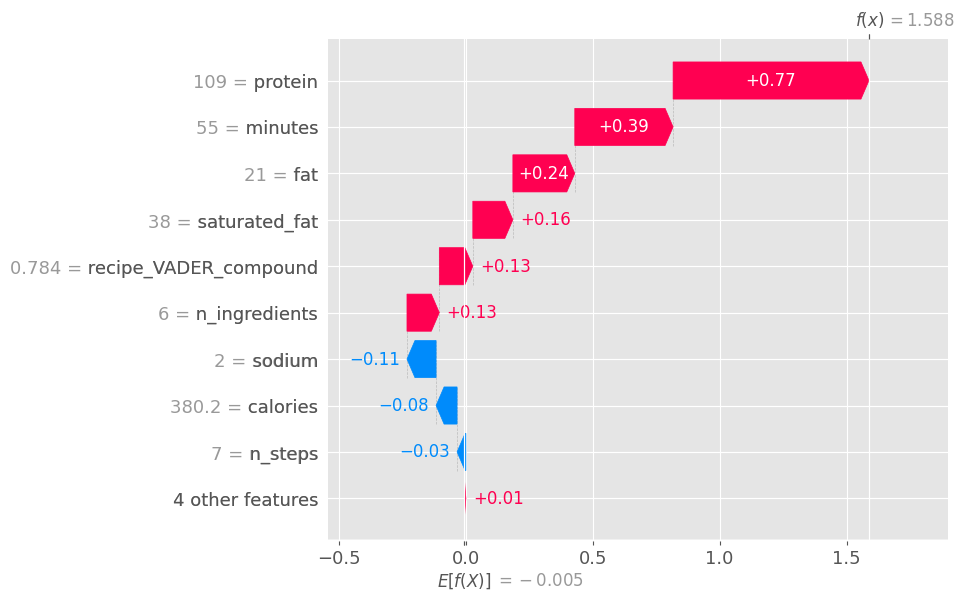

Prediction for food 8: shrimp cole slaw


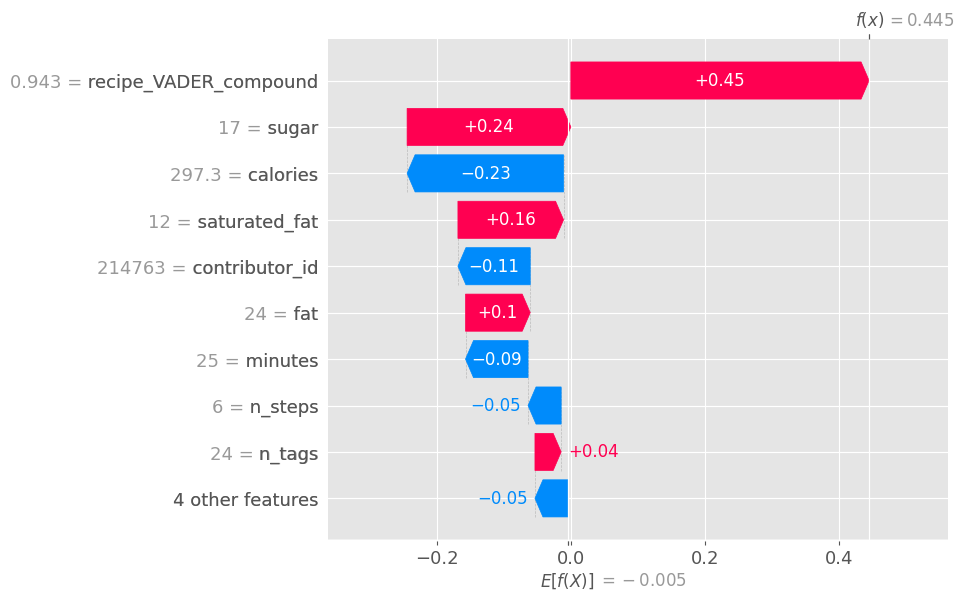

Prediction for food 9: pitcher bloody mary


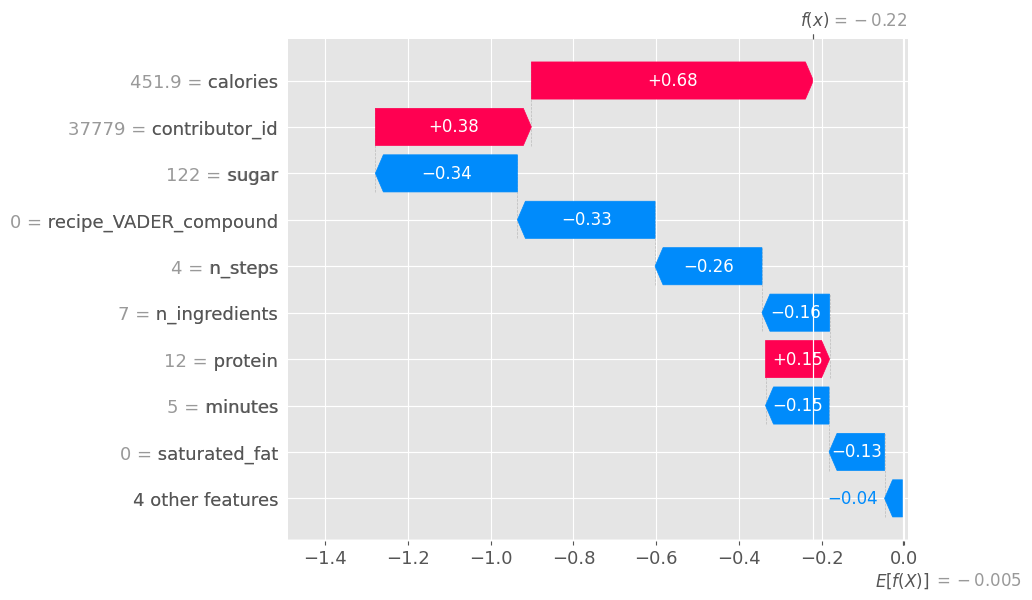

In [79]:
for i in range(10):
    print(f"Prediction for food {i}: {X_test_with_names.iloc[i]['name']}")
    shap.plots.waterfall(shap_values[i])

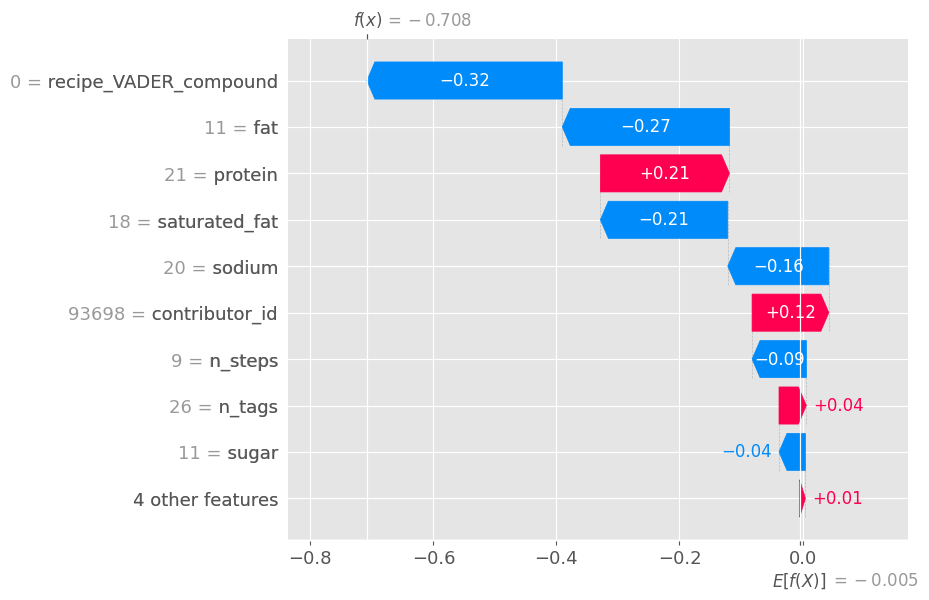

Prediction for food: benihana japanese fried rice


In [63]:
index = 0 
shap.plots.waterfall(shap_values[index])

food_name = X_test_with_names.iloc[index]['name']
print(f"Prediction for food: {food_name}")

In [64]:
#plot_feature_names = [name for name in feature_names if not name.startswith("embedding")]

In [65]:
plot_feature_names = ['minutes',
 'contributor_id',
 'n_steps',
 'n_ingredients',
 'calories',
 'fat',
 'sugar',
 'sodium',
 'protein',
 'saturated_fat',
 'carb',
 'recipe_VADER_compound',
 'n_tags']

['minutes',
 'contributor_id',
 'n_steps',
 'n_ingredients',
 'calories',
 'fat',
 'sugar',
 'sodium',
 'protein',
 'saturated_fat',
 'carb',
 'recipe_VADER_compound',
 'n_tags']

In [66]:
selected_indices = [feature_names.index(f) for f in plot_feature_names]

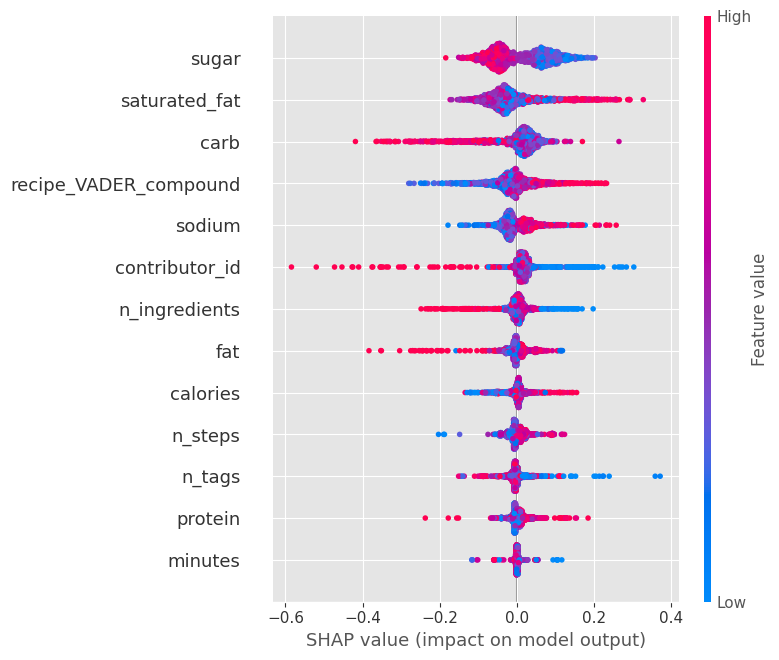

In [67]:
filtered_shap_values = shap_values[:, selected_indices]

X_test_filtered = X_test_transformed[:, selected_indices]

shap.summary_plot(filtered_shap_values, X_test_filtered, feature_names=plot_feature_names)

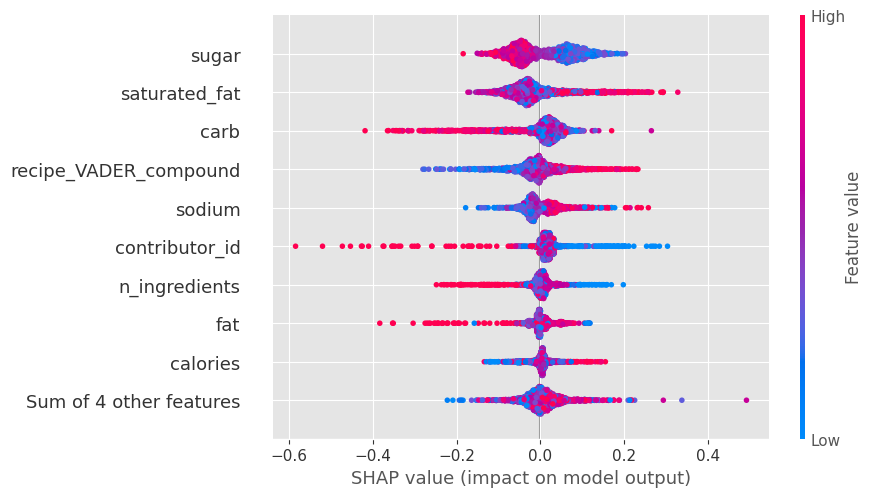

In [68]:
shap.plots.beeswarm(filtered_shap_values)


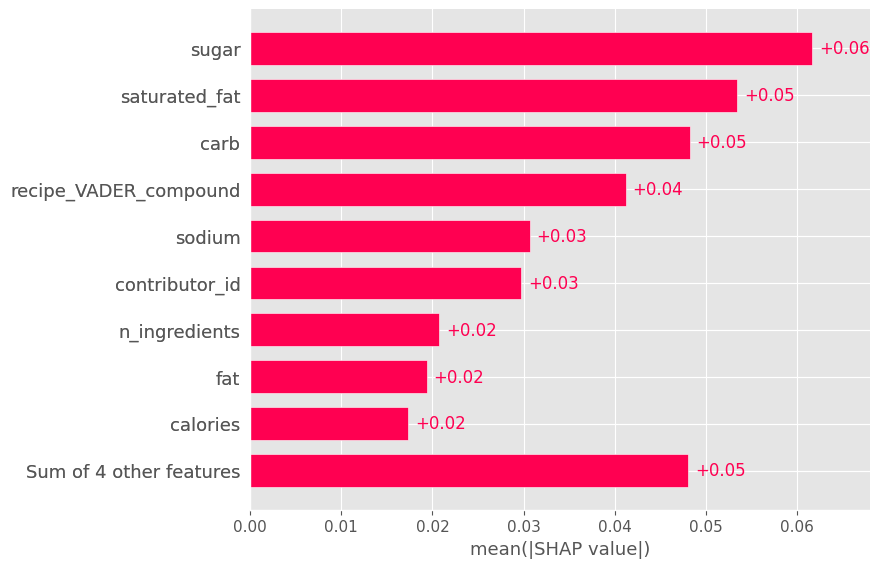

In [69]:
shap.plots.bar(filtered_shap_values)

In [74]:
df.description.values[7]

'a friend shared this with me last year. i have made a batch a month since then. it is an adaptation of a famous restaurants signature cheese. everyone likes it. it makes a great present. it will keep for extended periods when refrigerated but mine has never lasted more than a week. enjoy.'

In [72]:
df.name.values[5]

'25 pumpkin pie'

In [78]:
#X_train_aggregated

,minutes,contributor_id,n_steps,n_ingredients,calories,fat,sugar,sodium,protein,saturated_fat,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,-0.041163,0.043064,0.023051,0.078501,-0.052910,0.035220,0.046427,0.014127,-0.011763,-0.107239,...,7.0,183.3,16.0,51.0,6.0,6.0,29.0,6.0,0.9299,8.0
1,-0.048292,0.000207,0.033451,0.019950,0.046280,0.006847,0.112113,-0.050466,0.057694,-0.100011,...,6.0,184.3,10.0,87.0,8.0,13.0,27.0,8.0,0.9214,49.0
2,-0.036480,-0.042368,-0.000394,0.030890,0.027757,0.064120,0.053816,-0.043224,0.058415,-0.056689,...,11.0,231.9,28.0,20.0,5.0,8.0,13.0,5.0,0.7845,29.0
3,-0.115764,0.036390,-0.056319,-0.007628,-0.021236,0.029316,0.099910,-0.029036,0.004204,-0.035684,...,10.0,177.1,8.0,0.0,1.0,54.0,3.0,1.0,0.5719,9.0
4,-0.011482,0.054334,-0.029803,-0.030696,-0.100927,-0.022746,0.019816,-0.082762,0.062385,-0.039804,...,10.0,293.2,16.0,1.0,1.0,92.0,10.0,1.0,0.9380,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,-0.062658,-0.007335,0.022671,-0.031069,-0.022985,0.099870,-0.002519,-0.012135,0.007288,-0.014721,...,8.0,246.0,24.0,28.0,7.0,13.0,48.0,7.0,0.9617,14.0
6881,0.011027,0.043139,-0.097569,0.039322,-0.021399,0.056911,-0.035019,-0.081239,0.052033,-0.037015,...,18.0,547.5,34.0,193.0,25.0,14.0,54.0,25.0,0.7500,27.0
6882,-0.012237,0.025022,-0.080606,0.086808,-0.048791,0.045695,0.043540,-0.003707,0.040623,-0.063803,...,11.0,342.6,32.0,13.0,7.0,33.0,56.0,7.0,0.9929,24.0
6883,0.007865,-0.024330,-0.067257,0.096337,-0.019321,0.024227,0.028504,-0.052334,0.018443,-0.083536,...,7.0,335.1,27.0,5.0,2.0,68.0,25.0,2.0,0.9585,16.0
